# Calculating credible intervals
When we combine datasets, by default, we assume that each one is from the same population and that there is no sampling variance. If these assumptions are violated it would lead to overly tight confidence intervals. In reality these assumptions are rarely met and so by default `HLAfreq` does not supply credible intervals.

However, if we model this variance we can obtain accurate credible intervals for the combined allele frequencies. We can do this using `AFhdi()` from the `HLAfreq.HLAfreq_pymc` module which we import as `HLAhdi` below.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import HLAfreq
from HLAfreq import HLAfreq_pymc as HLAhdi

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Download dataset
country = "Mongolia"
locus = "DQB1"

base_url = HLAfreq.makeURL(country, locus=locus)
aftab = HLAfreq.getAFdata(base_url)
aftab = HLAfreq.only_complete(aftab)
HLAfreq.check_resolution(aftab)
aftab = HLAfreq.decrease_resolution(aftab, 2)
caf = HLAfreq.combineAF(aftab)

1 pages of results
Download complete
2    64
3     3
Name: allele, dtype: int64
Multiple resolutions in AFtab. Fix with decrease_resolution()


In [3]:
# Calculate high density intervals
hdi = HLAhdi.AFhdi(aftab, credible_interval=0.95)
# Add to the combined allele frequency dataset
caf = pd.merge(caf, hdi, how="left", on="allele")
caf[['allele', 'allele_freq', 'lo','hi','post_mean']]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [frac, conc]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


,allele,allele_freq,lo,hi,post_mean
0,DQB1*02:01,0.102965,0.069354,0.14193,0.107
1,DQB1*02:02,0.062476,0.025963,0.078963,0.052
2,DQB1*03:01,0.271881,0.220663,0.329699,0.275
3,DQB1*03:02,0.045532,0.022769,0.068847,0.045
4,DQB1*03:03,0.128528,0.066764,0.142278,0.103
5,DQB1*03:04,0.001752,0.000164,0.009574,0.004
6,DQB1*03:13,0.001752,0.000164,0.009965,0.004
7,DQB1*04:01,0.038527,0.016768,0.060056,0.038
8,DQB1*04:02,0.021780,0.013736,0.04914,0.03
9,DQB1*05:01,0.060791,0.034938,0.09162,0.062


Above, we have calculated the 95% high density credible interval and added it to the combined allele frequency dataset. Note that by setting the `credible_interval` argument you can calculate any credible interval.

This has also added a column `post_mean` which is the mean of the posterior distribution for allele frequency estimated by the model. In general this is very similar to the `allele_freq` estimated by default. The difference is that it takes account of the variances mentioned before. However, the difference can become large when there is heterogeneity in the dataset, which we will demonstrate below.

# How heterogenity affects credible intervals
As we saw in the [multiple country example](https://github.com/Vaccitech/HLAfreq/blob/main/examples/multi_country.ipynb)
Guinea was an outlier in our Sub-Saharan Africa data. Let's see how this causes the default allele frequency estimate to differ from the one accounting for variance.

In [4]:
# Download and combine country datasets
countries = ['Cameroon','Cape+Verde','Ghana','Guinea',
    'Guinea-Bissau', 'Kenya','Sao+Tome+and+Principe','Senegal',
    'South+Africa','Uganda','Zimbabwe']
cafs = []
for country in countries:
    print(country)
    base_url = HLAfreq.makeURL(
        country, standard='s', locus="A",
        resolution_pattern="bigger_equal_than", resolution=2)
    aftab = HLAfreq.getAFdata(base_url)
    # Drop any incomplete studies
    aftab = HLAfreq.only_complete(aftab)
    # Ensure all alleles have the same resolution
    aftab = HLAfreq.decrease_resolution(aftab, 2)
    # Combine studies within country
    caf = HLAfreq.combineAF(aftab)
    # Add country name to dataset, this is used as `datasetID` going forward
    caf['country'] = country
    cafs.append(caf)
cafs = pd.concat(cafs, ignore_index=True)
international = HLAfreq.combineAF(cafs, datasetID='country')


Cameroon
2 pages of results
Download complete
Cape+Verde
1 pages of results
Download complete
Ghana
1 pages of results
Download complete
Guinea
3 pages of results
Download complete
Guinea-Bissau
2 pages of results
Download complete
Kenya
2 pages of results
Download complete
Sao+Tome+and+Principe
1 pages of results
Download complete
Senegal
1 pages of results
Download complete
South+Africa
3 pages of results
Download complete
population               loci
South Africa Natal Zulu  A       0.935
Name: allele_freq, dtype: float64
1 studies have total allele frequency < 0.95
Uganda
1 pages of results
Download complete
Zimbabwe
1 pages of results
Download complete


In [5]:
# Calculate high density intervals
hdi = HLAhdi.AFhdi(cafs, credible_interval=0.95, datasetID='country')
# Add to the combined allele frequency dataset
international = pd.merge(international, hdi, how="left", on="allele")
international[['allele', 'allele_freq', 'lo','hi','post_mean']]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [frac, conc]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.


,allele,allele_freq,lo,hi,post_mean
0,A*01:01,0.047888,0.023436,0.051125,0.037
1,A*01:02,0.005929,0.003708,0.015222,0.009
2,A*01:03,0.002433,0.000601,0.006494,0.003
3,A*01:06,0.000412,0.000031,0.00343,0.001
4,A*01:09,0.000711,0.000155,0.00465,0.002
...,...,...,...,...,...
80,A*69:01,0.002848,0.003376,0.012452,0.008
81,A*74:01,0.044785,0.029114,0.059715,0.043
82,A*74:02,0.000286,0.000042,0.003404,0.001
83,A*74:03,0.004867,0.000736,0.007195,0.004


Below we plot default combined allele frequency estimate in orange and the individual country estimates in small blue points. The variance model results are plotted in black with a horizontal line representing the 95% credible interval and the mean of the posterior distribution as a verticle black bar.

In this plot we can see the three alleles with anomalously high frequency estimates for Guinea by the three very high blue points. For these alleles we can also see that the default estimate (in orange) is away from the variance model's estimate and actually outside of the 95% credible intervals.

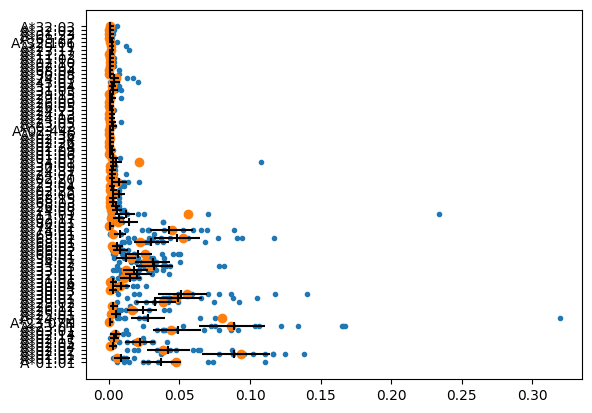

In [6]:
plt.scatter(cafs.allele_freq, cafs.allele, marker=".")
plt.scatter(international.allele_freq, international.allele)
plt.scatter(international.post_mean, international.allele, color='black', marker="|")
for interval in international.iterrows():
    plt.hlines(
        y=interval[1].allele,
        xmin=interval[1].lo,
        xmax=interval[1].hi,
        color='black'
    )
plt.show()

This separating of the two allele frequency estimates is caused by the heterogeneity. The variance model is able to account for this variance and so the posterior mean is not as strongly affected by these outlier values.

The default estimate (`allele_freq`) is simpler and faster to calculate. Whereas the variance model's `post_mean` accounts for variance and is less effected by outliers, but is slower and potentially suceptible to issues in convergence. Fortunately, in most cases they should be similar.

In cases where the default `allele_freq` falls outside of the 95% interval, like here, we have to make a choice. You could say one of:
1. "I want to capture the variance in the data" and so use the variance model to estimate `post_mean`. 
2. "After looking carefully at the sample sizes and where those data points come from I think they are anomalies" and so exclude those datasets and recalculate. Note that you would exclude the whole dataset (in this case Guniea) not merely the outlier alleles. The choice to exclude datasets could be based on small sample size (although small studies shouldn't have a large effect on the combined value), domain knowledge, or details of how that data was collected. These details are available on [allelefrequencies.net](http://www.allelefrequencies.net) if you look up the population.
3. "After looking at the model validation plots I think the variance model has failed to converge on the correct answer" and so use the default `allele_freq`. Or dive into `pymc` to try and fit a better model.

# Model details

This section describes the variance model in more detail as well as how to access the model and assess convergence.

The variance model used to estiamte high posterior density interval and `post_mean` is a Marginalized Dirichlet-Multinomial Model in PyMc as described [here](https://docs.pymc.io/en/v3/pymc-examples/examples/mixture_models/dirichlet_mixture_of_multinomials.html).

In brief, the global allele frequency is modelled as a Dirichlet distribution,
and each population (defined by `datasetID`) is a Dirichlet distribution draw from
the global Dirichlet distribution, and the observed allele count data of that
population is multinomial count data drawn from the population Dirichlet distribution.

The observed allele frequencies are transformed into allele counts using `weights`.
The variability of population allele frequencies around the global mean is defined
by a latent, lognormal variable `conc`.

## Fitting the model
If you suspect that the model is failing to converge you can fit the model and check it directly. The code to fit the model below is the same that `AFhdi()` uses internally. 

In [7]:
# Format data and fit variance model
c_array, allele_names = HLAhdi._make_c_array(cafs, '2n', 'country')
idata = HLAhdi._fit_Dirichlet_Multinomial(c_array)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [frac, conc]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.


## Validating the model
Once you have fit the model you can validate it as you would any other PyMC model. A basic overview is available [here](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html#model-checking) and a more detailed check for biased parameters is described [here](https://www.pymc.io/projects/examples/en/latest/diagnostics_and_criticism/Diagnosing_biased_Inference_with_Divergences.html#diagnosing-with-divergences).

Some basic checks are shown below. It's a good idea to check the `r_hat` values are close to 1. Higher `r_hat` values indicate that some chains have failed to converge and `pymc` will also give warnings for high values.

In [8]:
import arviz as az
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
frac[0],0.037,0.008,0.023,0.051,0.000,0.000,5490.0,2580.0,1.0
frac[1],0.009,0.003,0.004,0.015,0.000,0.000,4089.0,2460.0,1.0
frac[2],0.003,0.002,0.001,0.006,0.000,0.000,5394.0,1994.0,1.0
frac[3],0.001,0.001,0.000,0.003,0.000,0.000,4160.0,2185.0,1.0
frac[4],0.002,0.001,0.000,0.004,0.000,0.000,3872.0,2148.0,1.0
...,...,...,...,...,...,...,...,...,...
frac[81],0.043,0.008,0.029,0.059,0.000,0.000,5169.0,2694.0,1.0
frac[82],0.001,0.001,0.000,0.003,0.000,0.000,3996.0,2170.0,1.0
frac[83],0.004,0.002,0.001,0.007,0.000,0.000,4565.0,2570.0,1.0
frac[84],0.014,0.004,0.008,0.021,0.000,0.000,3645.0,2511.0,1.0


An energy plot can check that the sampler performed well, if it did the two distributions should be similar.


<AxesSubplot: >

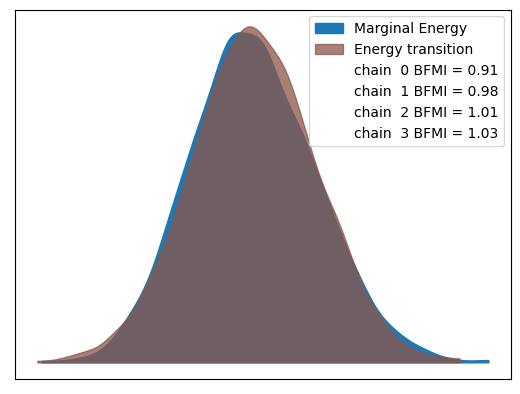

In [9]:
az.plot_energy(idata)


Trace plots can also be used to check convergence and mixing. In the left hand plots we want the different chains to have converged to the same distributions. And in the right hand plot we want to see no trends or evidence of chains getting stuck.

With large numbers of alleles you may have to increase the max_subplots to see all alleles and avoid warnings.

/home/dwells/miniconda3/envs/hlatest/lib/python3.10/site-packages/arviz/plots/traceplot.py:217: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (86), generating only 20 plots
  warnings.warn(


array([[<AxesSubplot: title={'center': 'frac\n0'}>,
        <AxesSubplot: title={'center': 'frac\n0'}>],
       [<AxesSubplot: title={'center': 'frac\n1'}>,
        <AxesSubplot: title={'center': 'frac\n1'}>],
       [<AxesSubplot: title={'center': 'frac\n2'}>,
        <AxesSubplot: title={'center': 'frac\n2'}>],
       [<AxesSubplot: title={'center': 'frac\n3'}>,
        <AxesSubplot: title={'center': 'frac\n3'}>],
       [<AxesSubplot: title={'center': 'frac\n4'}>,
        <AxesSubplot: title={'center': 'frac\n4'}>],
       [<AxesSubplot: title={'center': 'frac\n5'}>,
        <AxesSubplot: title={'center': 'frac\n5'}>],
       [<AxesSubplot: title={'center': 'frac\n6'}>,
        <AxesSubplot: title={'center': 'frac\n6'}>],
       [<AxesSubplot: title={'center': 'frac\n7'}>,
        <AxesSubplot: title={'center': 'frac\n7'}>],
       [<AxesSubplot: title={'center': 'frac\n8'}>,
        <AxesSubplot: title={'center': 'frac\n8'}>],
       [<AxesSubplot: title={'center': 'frac\n9'}>,
   

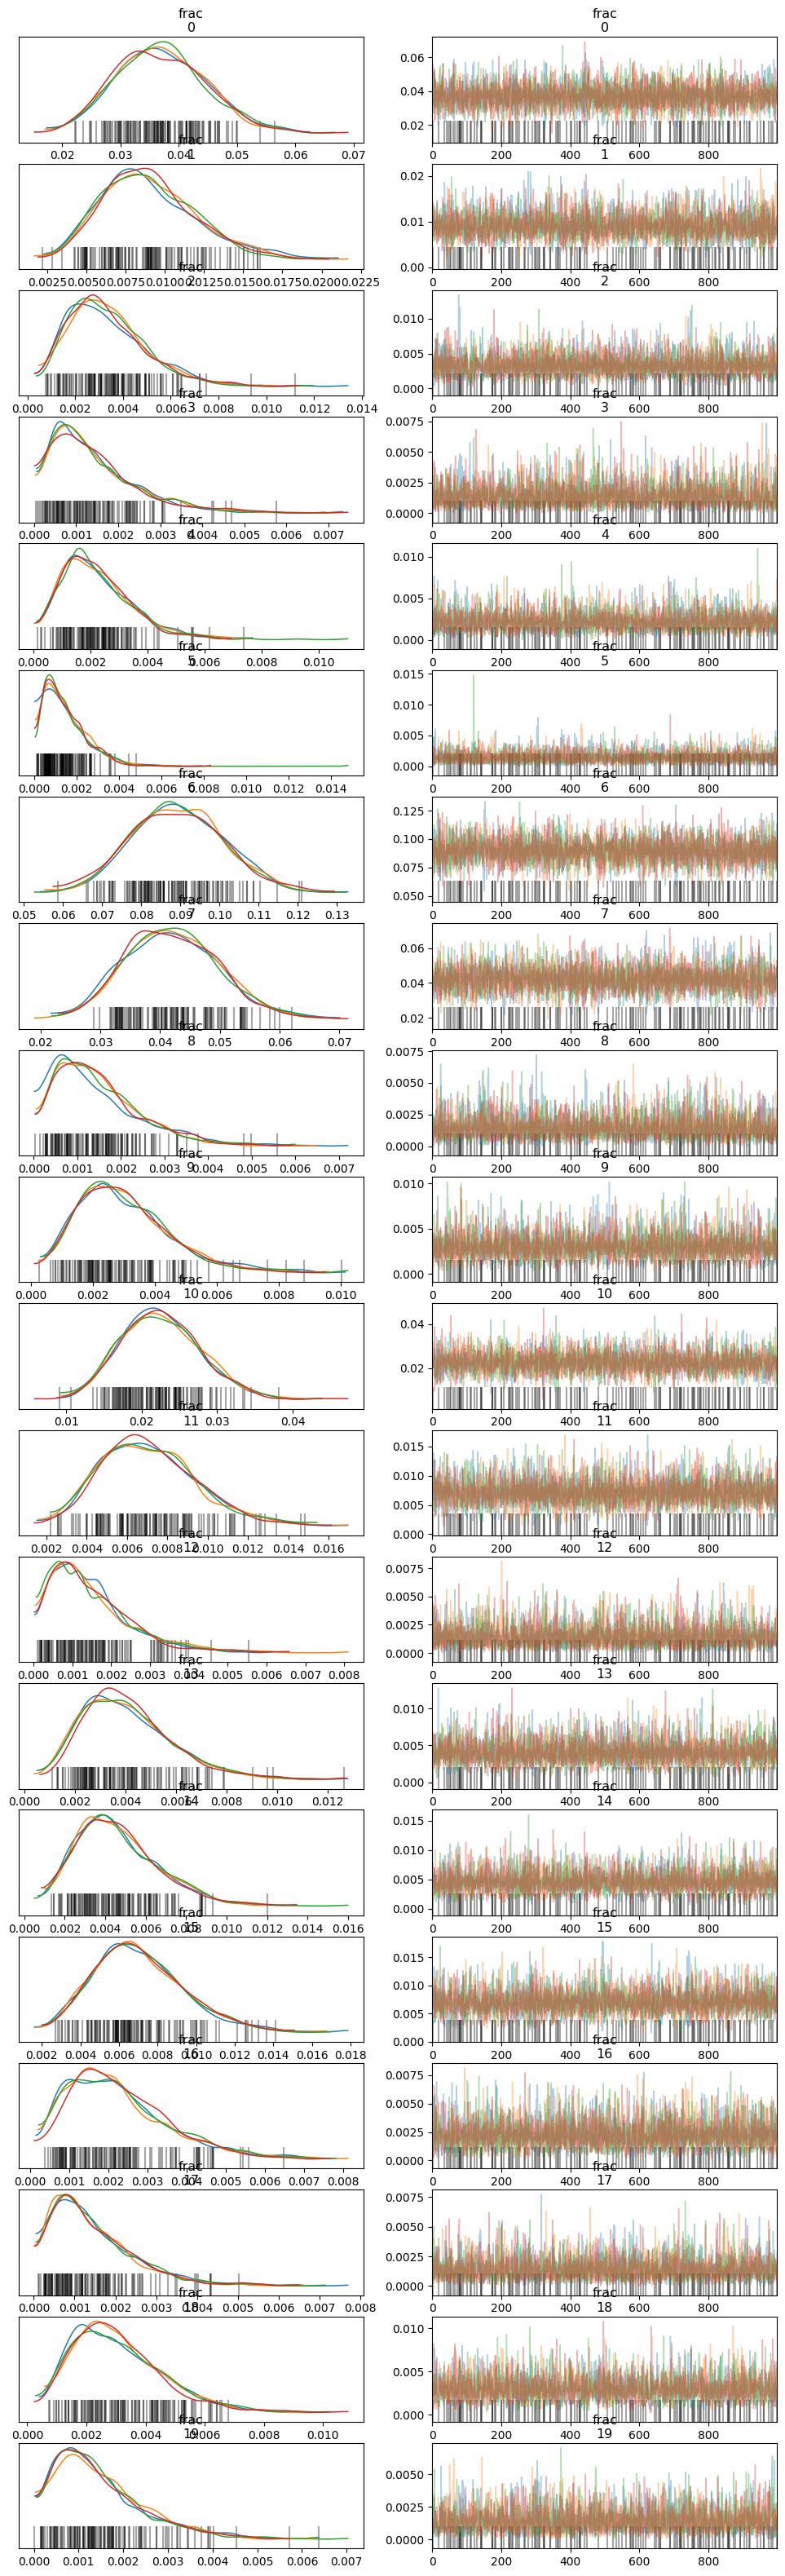

In [10]:

az.plot_trace(idata, compact=False, combined=False)